Supervisor:			Prof. Dr. Elmar Lukas

Name: 				Muhammad Daniyal Khan, 
                    Zhraan Sheikh
                    
Email: 				muhammad13.khan@st.ovgu.de,
                    zhraan.sheikh@st.ovgu.de
                    
Matriculation #:    254480,
                    253411

Program: 			MSc Financial Economics

Group #:            8 Chooser Option

# Testing prerequisites for GBM

In [3]:
!pip install yfinance
!pip install pandas-datareader
!pip install option-price
!pip install chart_studio
import numpy as np
import scipy as sp
import scipy.stats as stats
import math
import time
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from pandas_datareader import data
from plotly.offline import iplot
from statsmodels.graphics.gofplots import qqplot
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np
from scipy.stats import jarque_bera
from scipy.stats import shapiro
from scipy.stats import norm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch


%load_ext autoreload
%autoreload 2

## GBM Simulations

In [5]:

ticker = "ASML"
periods = {
    '1-Year': '1y',
    '2-Year': '2y',
    '5-Year': '5y'
}

processed_data = {}

for label, period in periods.items():
    df = yf.download(ticker, period=period, auto_adjust=True)

    # Flatten MultiIndex columns
    df.columns = df.columns.get_level_values(0)

    print(f"{label} shape: {df.shape}")
    print("Columns:", df.columns.tolist())

    if df.empty:
        print(f"Warning: No data downloaded for {label}")
        continue

    try:
        df['Price'] = df['Close']
        df = df.dropna(subset=['Price'])
        df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1)).dropna()
        processed_data[label] = df

    except Exception as e:
        print(f"Error processing {label}: {e}")

# Final outputs
df_1yr = processed_data.get('1-Year')
df_2yr = processed_data.get('2-Year')
df_5yr = processed_data.get('5-Year')

if df_1yr is not None:
    log_returns1 = df_1yr['Log_Returns'].dropna()
if df_2yr is not None:
    log_returns2 = df_2yr['Log_Returns'].dropna()
if df_5yr is not None:
    log_returns5 = df_5yr['Log_Returns'].dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


1-Year shape: (251, 5)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
2-Year shape: (502, 5)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']


[*********************100%***********************]  1 of 1 completed

5-Year shape: (1256, 5)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']


# The standard gBM model assumes:

Log returns are normally distributed Constant drift (μ) and volatility (σ) 
No autocorrelation (returns are independent) 
Continuous price paths (no jumps) 

## For each time window we will test by: 
* Checking if log returns normally distributed Histograms, q-q plots and normality tests (shapiro-wilk, jarque bera) 
* Checking if returns independent acf/pacf plots on log returns or Ljung box-test 
* Is volatility constant Check for heteroskedasticity using ARCH test or plot rolling volatility 
* Visual inspection Plot the log-price vs time - GBM implies linear growth in log-price with noise


# Checking 1 year data


In [18]:
#Checking if log returns are normally distributed using JB test

stat, p = jarque_bera(log_returns1)
stat, p1 = shapiro(log_returns1)

print(p)
print(p1)

3.981386537140594e-133
3.3459947442502844e-12


Both results from the Shapiro and JB tests confirm that the P values are less than 0.05 which means that the Log returns are not normally distributed.

In [89]:
#Conducting Ljung Box-Test to check if returns are independent

results = acorr_ljungbox(log_returns1.dropna(), lags=[10], return_df=True)

print(results)

     lb_stat  lb_pvalue
10  8.975925    0.53439


Here the P-Value is 0.53 > 0.05 therefore the returns are likely independent

In [93]:
#Conducting ARCH test to see if volatility is constant, if a time series follows, GBM volatility should be constant

arch_test = het_arch(log_returns1.dropna(), nlags=12)
print(arch_test)

(6.231102739825318, 0.9039867997897522, 0.5040934213039475, 0.9109095329729416)


* Test Statistic: 6.23
* P-value: 0.90	

0.90>0.05 therefore we fail to reject the null. Volatility appears to be constant.

A process follows GBM if it satisfies the stochastic differential equation: dSt = mu(St)dt + sigmaStd(Wt), where St is the price, mu is the drift, sigma is the volatility, and Wt is a standard Brownian motion.

We will estimate mu and sigma and then simulate future prices using GBM and then compare those simulated prices to real log returns and compare. GBM implies that log-prices should grow linearly in expectation:


In [97]:
#https://github.com/YanaSSS/model-stock-price-dynamics-using-SDE/blob/master/Modeling%20Stock%20Price%20Dynamics%2C%20using%20Stochastic%20Differential%20Equation.ipynb

mu_1yr = df_1yr['Log_Returns'].mean() * 252
sigma_1yr = df_1yr['Log_Returns'].std() * np.sqrt(252)

print(mu_1yr)
print(sigma_1yr)

#GBM based on real stock prices

# Parameters:
# So - initial stock price 
# mu - the mean of returns 
# sigma - standard deviation of returns (volatility)
# W - Brownian motion
# T - time horizon
# N - number of intervals

def GBM_Exact(So, mu, sigma, W, N, t):
    
    S = []
    S.append(So)
          
    for i in range(1,N):
        drift = (mu - 0.5 * sigma**2) *t[i]       #Calculating the deterministic part
        diffusion = sigma * W[i-1]                #Calculating the stochastic part
        S_i = So * np.exp(drift + diffusion)
        S.append(S_i)
        
    return S

T = 1.        #time interval
N = min(250, len(df_1yr)) 
#N = 250        #number of points
seed = 20
dt = T / N                 #time step
t = np.arange(0.0, 1.0, dt)

-0.27742899029819157
0.4817883291812445


In [99]:
def BrownianMotion(seed, N):
    
    np.random.seed(seed)

    Z = np.random.randn(N)     #random variables
    Z[0] = 0
    
    dW = np.sqrt(dt)* Z        #single Brownian increment
    
    W = np.cumsum(dW)          #Brownian path
    
    return W


So = df_1yr['Price'].iloc[0] 
W = BrownianMotion(seed, N)
N = min(250, len(df_1yr)) 
#N = 250     #assume 250 trading days for one year   
T = 1.0        
t = np.linspace(0., T, N)    #time increments

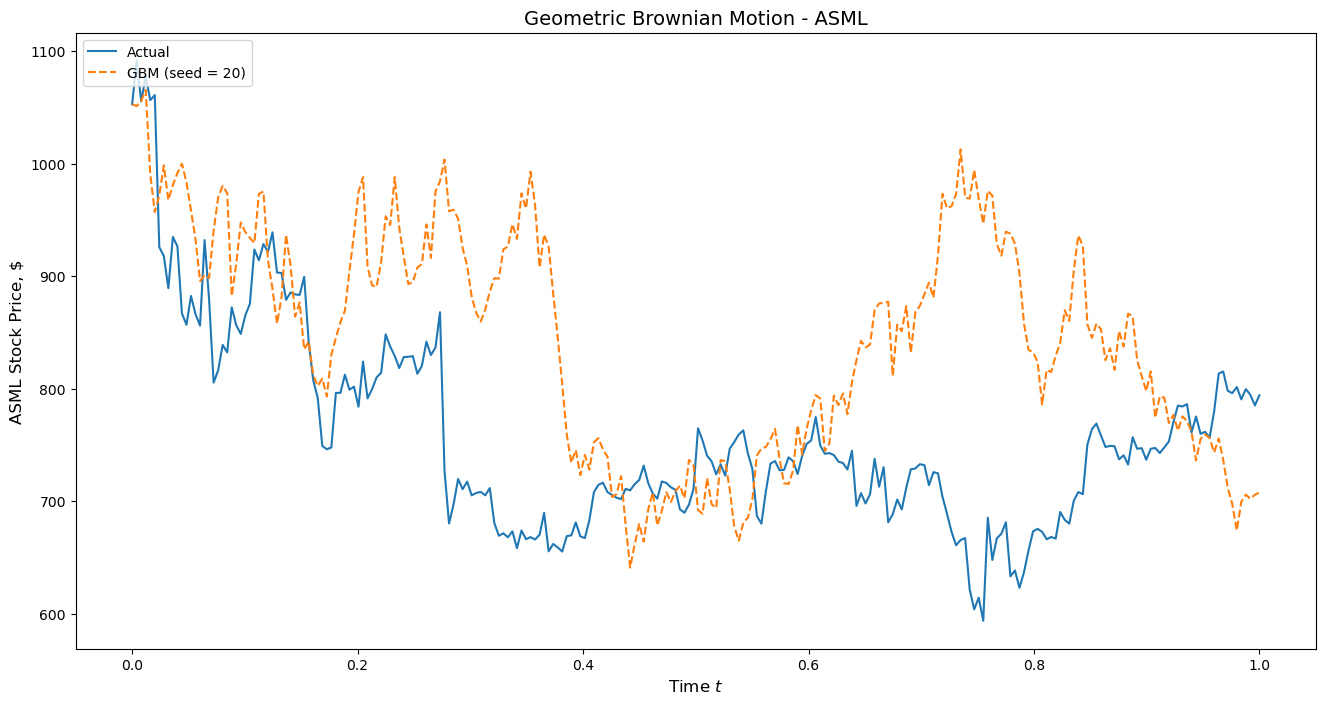

In [101]:
actual_prices = df_1yr['Price'].iloc[:N].values
solution = GBM_Exact(So, mu_1yr, sigma_1yr, W, N, t)

plt.figure(figsize = (16, 8))
plt.plot(t, actual_prices, label = 'Actual')
plt.plot(t, solution, label = 'GBM (seed = 20)', ls='--')
plt.xlabel('Time $t$', fontsize = 12)
plt.ylabel('ASML Stock Price, $', fontsize = 12)
plt.title('Geometric Brownian Motion - ASML', fontsize = 14)
plt.legend(loc = 'upper left')
axes = plt.gca()
plt.show()

From the above plot we see that the stock does not accurately follow the GBM simulation

#### Conclusion -  1 Year

Cannot conclude that 1 year ASML follows GBM due to the violation of the normality assumption. While the independence and constant volatility conditions are met, the non-normal distribution of log returns is a fundamental requirement that's not satisfied and the graph does not visually confirm that the price follows GBM. 

# Checking 2 year data

In [106]:
stat, p = jarque_bera(log_returns2)
stat, p1 = shapiro(log_returns2)

print(p)
print(p1)

2.9226816277939818e-269
4.0022503665939145e-16


Both results from the Shapiro and JB tests confirm that the P values are less than 0.05 which means that the Log returns are not normally distributed.

In [109]:
#Conducting Ljung Box-Test to check if returns are independent

results = acorr_ljungbox(log_returns2.dropna(), lags=[10], return_df=True)

print(results)

    lb_stat  lb_pvalue
10  7.84536   0.643939


Here the P-Value is 0.64 > 0.05 therefore the returns are likely independent

In [113]:
#Conducting ARCH test to see if volatility is constant, if a time series follows, GBM volatility should be constant

arch_test = het_arch(log_returns2.dropna(), nlags=12)
print(arch_test)



(10.154222465050132, 0.6024328105319765, 0.8411563319067245, 0.6078174925552969)


* Test Statistic: 10.15
* P-value: 0.60

0.60 > 0.05 therefore we fail to reject the null. Volatility appears to be constant.

0.06757896675935617
0.41645278635336613


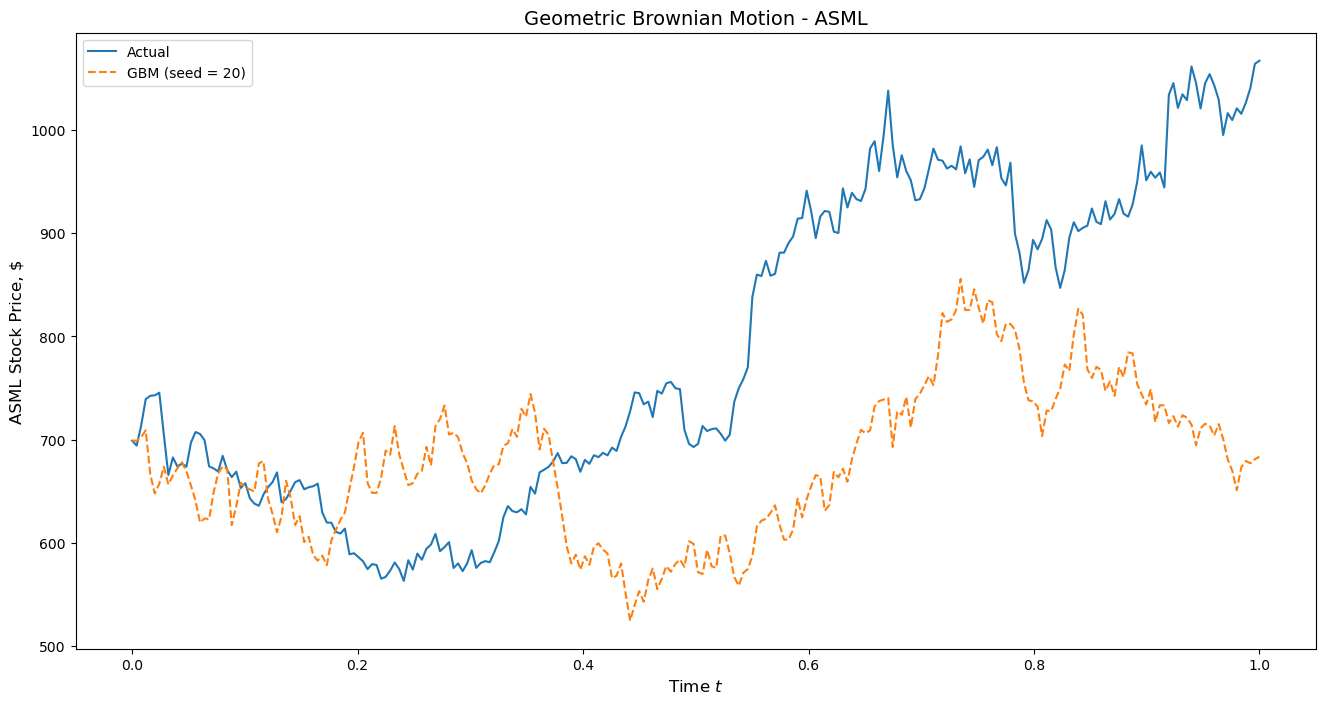

In [116]:
mu_2yr = df_2yr['Log_Returns'].mean() * 252
sigma_2yr = df_2yr['Log_Returns'].std() * np.sqrt(252)

print(mu_2yr)
print(sigma_2yr)

#GBM based on real stock prices

# Parameters:
# So - initial stock price 
# mu - the mean of returns 
# sigma - standard deviation of returns (volatility)
# W - Brownian motion
# T - time horizon
# N - number of intervals

def GBM_Exact(So, mu, sigma, W, N, t):
    
    S = []
    S.append(So)
          
    for i in range(1,N):
        drift = (mu - 0.5 * sigma**2) *t[i]       #Calculating the deterministic part
        diffusion = sigma * W[i-1]                #Calculating the stochastic part
        S_i = So * np.exp(drift + diffusion)
        S.append(S_i)
        
    return S

T = 1.        #time interval
N = min(250, len(df_2yr)) 
#N = 250        #number of points
seed = 20
dt = T / N                 #time step
t = np.arange(0.0, 1.0, dt)

def BrownianMotion(seed, N):
    
    np.random.seed(seed)

    Z = np.random.randn(N)     #random variables
    Z[0] = 0
    
    dW = np.sqrt(dt)* Z        #single Brownian increment
    
    W = np.cumsum(dW)          #Brownian path
    
    return W


So = df_2yr['Price'].iloc[0] 
W = BrownianMotion(seed, N)
N = min(250, len(df_2yr)) 
#N = 250     #assume 250 trading days for one year   
T = 1.0        
t = np.linspace(0., T, N)    #time increments

actual_prices2 = df_2yr['Price'].iloc[:N].values
solution2 = GBM_Exact(So, mu_2yr, sigma_2yr, W, N, t)

plt.figure(figsize = (16, 8))
plt.plot(t, actual_prices2, label = 'Actual')
plt.plot(t, solution2, label = 'GBM (seed = 20)', ls='--')
plt.xlabel('Time $t$', fontsize = 12)
plt.ylabel('ASML Stock Price, $', fontsize = 12)
plt.title('Geometric Brownian Motion - ASML', fontsize = 14)
plt.legend(loc = 'upper left')
axes = plt.gca()
plt.show()

#### Conclusion -  2 Year

Cannot conclude that 2 year ASML follows GBM due to the violation of the normality assumption. While the independence and constant volatility conditions are met, the non-normal distribution of log returns is a fundamental requirement that's not satisfied and the graph does not visually confirm that the price follows GBM. 

## Checking 5 year data

In [120]:
stat, p = jarque_bera(log_returns5)
stat, p1 = shapiro(log_returns5)

print(p)
print(p1)

1.207511881283326e-158
5.388135023640132e-16


Both results from the Shapiro and JB tests confirm that the P values are less than 0.05 which means that the Log returns are not normally distributed.

In [123]:
#Conducting Ljung Box-Test to check if returns are independent

results = acorr_ljungbox(log_returns5.dropna(), lags=[10], return_df=True)

print(results)

      lb_stat  lb_pvalue
10  15.634636    0.11058


Here the P-Value is 0.11 > 0.05 therefore the returns are likely independent

In [127]:
#Conducting ARCH test to see if volatility is constant, if a time series follows, GBM volatility should be constant

arch_test = het_arch(log_returns5.dropna(), nlags=12)
print(arch_test)



(23.437172133524754, 0.02423561380792497, 1.969812533470646, 0.0237069129783702)


* Test Statistic: 23.43
* P-value: 0.02	

0.02 > 0.05 therefore we reject the null. Volatility does not appears to be constant.

0.15018135357622464
0.41451810292264013


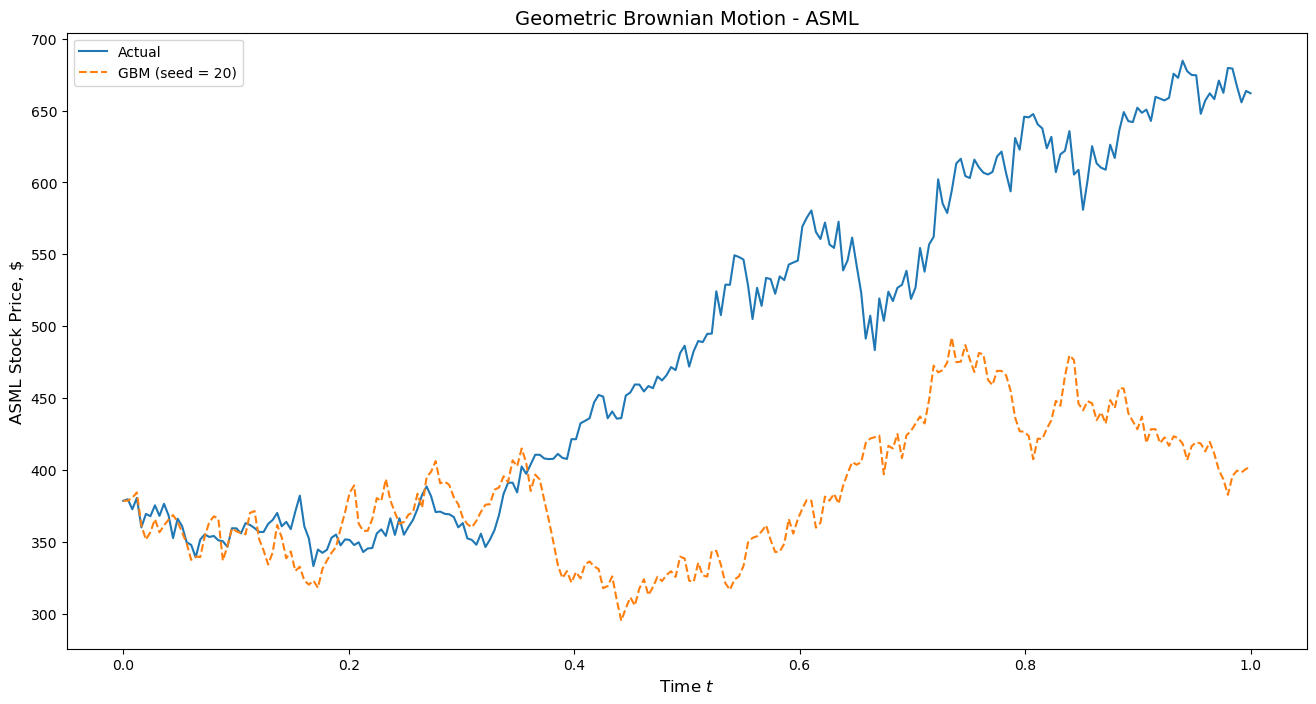

In [131]:
mu = df_5yr['Log_Returns'].mean() * 252
sigma = df_5yr['Log_Returns'].std() * np.sqrt(252)

print(mu)
print(sigma)

def GBM_Exact(So, mu, sigma, W, N, t):
    
    S = []
    S.append(So)
          
    for i in range(1,N):
        drift = (mu - 0.5 * sigma**2) *t[i]       #Calculating the deterministic part
        diffusion = sigma * W[i-1]                #Calculating the stochastic part
        S_i = So * np.exp(drift + diffusion)
        S.append(S_i)
        
    return S

T = 1.        #time interval
N = min(250, len(df_5yr)) 
#N = 250        #number of points
seed = 20
dt = T / N                 #time step
t = np.arange(0.0, 1.0, dt)

def BrownianMotion(seed, N):
    
    np.random.seed(seed)

    Z = np.random.randn(N)     #random variables
    Z[0] = 0
    
    dW = np.sqrt(dt)* Z        #single Brownian increment
    
    W = np.cumsum(dW)          #Brownian path
    
    return W


So = df_5yr['Price'].iloc[0] 
W = BrownianMotion(seed, N)
N = min(250, len(df_5yr)) 
T = 1.0        
t = np.linspace(0., T, N)    #time increments

actual_prices = df_5yr['Price'].iloc[:N].values
solution = GBM_Exact(So, mu, sigma, W, N, t)

plt.figure(figsize = (16, 8))
plt.plot(t, actual_prices, label = 'Actual')
plt.plot(t, solution, label = 'GBM (seed = 20)', ls='--')
plt.xlabel('Time $t$', fontsize = 12)
plt.ylabel('ASML Stock Price, $', fontsize = 12)
plt.title('Geometric Brownian Motion - ASML', fontsize = 14)
plt.legend(loc = 'upper left')
axes = plt.gca()
plt.show()

#### Conclusion -  5 Year

Cannot conclude that 5 year ASML follows GBM due to the violation of the normality and constant volatility assumption. While the independence condition is met, the non-normal distribution of log returns and constant volatility is a fundamental requirement that's not satisfied and the graph does not visually confirm that the price follows GBM. 

# Black Scholes Options Pricing Models for Call and Put Options 

### Black-Scholes Model Explained

The Black-Scholes model is a mathematical framework for pricing **European-style options** (exercisable only at expiration). 

---


#### Formulae
First, we calculate two intermediate values, $d_1$ and $d_2$:

1.  **Formula for $d_1$:**
    $$d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}$$

2.  **Formula for $d_2$:**
    $$d_2 = d_1 - \sigma\sqrt{T}$$

Once $d_1$ and $d_2$ are calculated, we can determine the prices of the call and put options:

3.  **Black-Scholes Call Option Price ($C$):**
    $$C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$$

4.  **Black-Scholes Put Option Price ($P$):**
    $$P = K \cdot e^{-rT} \cdot N(-d_2) - S \cdot N(-d_1)$$

In [137]:
# Black-Scholes Option Pricing Function
def black_scholes(S, K, T, r, sigma, option_type='call', q=0.0):
    """
    Calculate Black-Scholes option price.
    
    Parameters:
        S (float): Current stock price
        K (float): Strike price
        T (float): Time to expiration (in years)
        r (float): Risk-free rate
        sigma (float): Volatility
        option_type (str): 'call' or 'put'
        q (float): Dividend yield (default 0)
    """
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == 'call':
        price = S*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    elif option_type == 'put':
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-q*T)*norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    return price

# Options Strategy - Chooser Option

A chooser option (sometimes referred to as an as you like it option) has the feature that,
after a specified period of time, the holder can choose whether the option is a call or a
put. This enables option holder to take a long position on the volatility of the underlying stock to create a V shaped payoff. 

This is created as a combination of 
1. Call option expiring at T_Expiry
2. Put option expiring at T_Choice which is before T_Expiry

At choice date, 
1. If the holder chooses the call option, they keep the original call (which still has value until T_expiry), and the special put expires worthless.
2. If the holder chooses the put option, they exercise the special put to get:

    i. Cash: $K*e^{-r(Texpiry - Tchoice)}$
   
    ii. Which can be invested at risk-free rate r to become exactly K at T_expiry

   iii. This cash plus the original call option recreates the put option value through put-call parity

In [141]:
# Chooser Option Pricing Function
def chooser_option(S, K, T_choice, T_expiry, r, sigma, q=0.0):
    """
    Price a chooser option using put-call parity equivalence.
    
    Parameters:
        S: Current stock price
        K: Strike price
        T_choice: Time to choice date (years)
        T_expiry: Time to expiration (years)
        r: Risk-free rate
        sigma: Volatility
        q: Dividend yield (default 0)
    """
    # Price call option with full expiration
    call = black_scholes(S, K, T_expiry, r, sigma, 'call', q)
    
    # Calculate adjusted strike for put option
    adjusted_strike = K * np.exp(-r * (T_expiry - T_choice))
    
    # Price put option expiring at choice date
    put_choice = black_scholes(S, adjusted_strike, T_choice, r, sigma, 'put', q)
    
    return call + put_choice

In [143]:
# Calculate annualized parameters from 1-year data
trading_days_per_year = 249

# Set option parameters
option_life = 60 / trading_days_per_year  # 60-day option in years
choice_date = 30 / trading_days_per_year  # Choice date at midpoint
r = 0.04207  # Risk-free rate (US 10Y Treasury Note rate - 1Y Average)
q = 0.00  # Dividend yield 

# Initialize lists with NaN for all rows
chooser_prices = [np.nan] * len(df_1yr)
call_prices = [np.nan] * len(df_1yr)
put_prices = [np.nan] * len(df_1yr)

In [145]:
for i in range(len(df_1yr)):
    S_t = df_1yr['Price'].iloc[i]
    
    # Price ATM options (strike = current price)
    call = black_scholes(S_t, S_t, option_life, r, sigma_1yr, 'call', q)
    put = black_scholes(S_t, S_t, option_life, r, sigma_1yr, 'put', q)
    
    # Price chooser option 
    chooser = chooser_option(S_t, S_t, choice_date, option_life, r, sigma_1yr, q)
    
    # Store results
    call_prices[i] = call
    put_prices[i] = put
    chooser_prices[i] = chooser

# Add to DataFrame
df_1yr['Chooser_Price'] = chooser_prices
df_1yr['Call_Price'] = call_prices
df_1yr['Put_Price'] = put_prices



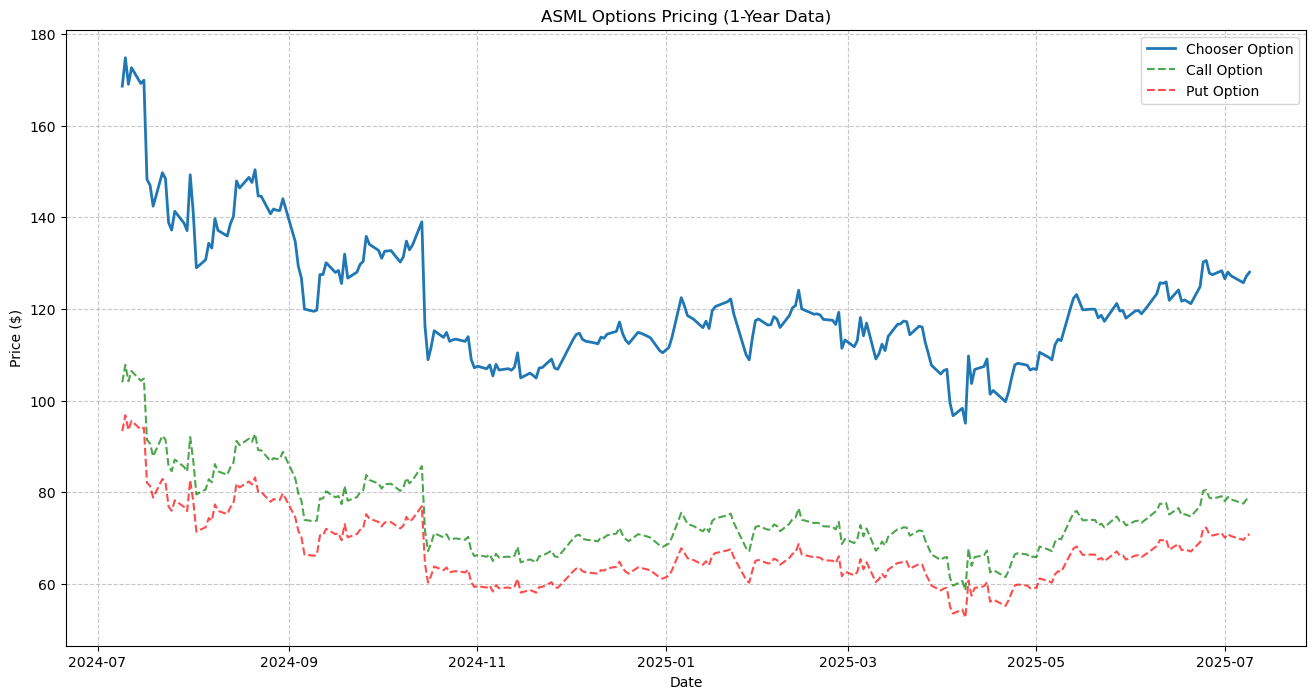

In [147]:
# Trend of standalone options and chooser option
plt.figure(figsize = (16, 8))
plt.plot(df_1yr.index, df_1yr['Chooser_Price'], label='Chooser Option', linewidth=2)
plt.plot(df_1yr.index, df_1yr['Call_Price'], 'g--', label='Call Option', alpha=0.7)
plt.plot(df_1yr.index, df_1yr['Put_Price'], 'r--', label='Put Option', alpha=0.7)
plt.title('ASML Options Pricing (1-Year Data)')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Contrast with Market Prices and Sensitivities

In [150]:

# Full dataset searched on yahoofinance for At-The-Money options. The criteria used in +- 3% moneyness. This data cannot be imported directly therefore it had to be manually searched. 
cop_prices = {
    'Date': [
        '2024-07-01', '2024-08-01', '2024-09-03', '2024-10-01', '2024-11-01', '2024-12-02',
        '2025-01-02', '2025-02-03', '2025-03-03', '2025-04-01', '2025-05-01', '2025-06-02'
    ],
    'ASML Opening Price': [
        1028.60, 996.40, 945.80, 885.30, 832.50, 780.10,
        735.90, 698.40, 655.20, 610.50, 765.80, 785.09
    ],
    'ATM Strike (X)': [
        1030, 995, 945, 885, 830, 780,
        735, 700, 655, 610, 765, 785
    ],
    'Short 30D Put Premium': [
        32.10, 30.50, 29.80, 33.90, 31.20, 29.50,
        27.10, 26.80, 30.10, 28.90, 26.30, 31.56
    ],
    'Long 60D Call Premium': [
        61.80, 58.20, 55.10, 59.40, 56.80, 53.30,
        49.60, 47.20, 51.50, 48.70, 44.90, 43.50
    ],
    'Moneyness': [
        -0.0014, 0.0014, 0.0008, 0.0003, 0.0030, 0.0001,
        0.0012, -0.0023, 0.0003, 0.0008, 0.0010, 0.0001
    ]
}

# Convert to DataFrame
cop_prices = pd.DataFrame(cop_prices)

# Convert date column to datetime format
cop_prices['Date'] = pd.to_datetime(cop_prices['Date'])




In [152]:
#combining the call and put into chooser options
cop_prices['Chooser Option'] =cop_prices['Short 30D Put Premium']+cop_prices['Long 60D Call Premium']

In [153]:
# Reset index to make 'Date' a column for merging
cop_prices_reset = cop_prices.reset_index()
df_1yr_reset = df_1yr.reset_index()

# Now perform the merge
comparison_df = pd.merge(
    left=cop_prices_reset,
    right=df_1yr_reset[['Date', 'Chooser_Price']],
    on='Date',
    how='inner'
)

comparison_df = comparison_df.rename(columns={
    'Chooser Option': 'Synthetic_Chooser',
    'Chooser_Price': 'Modelled_Chooser'
})



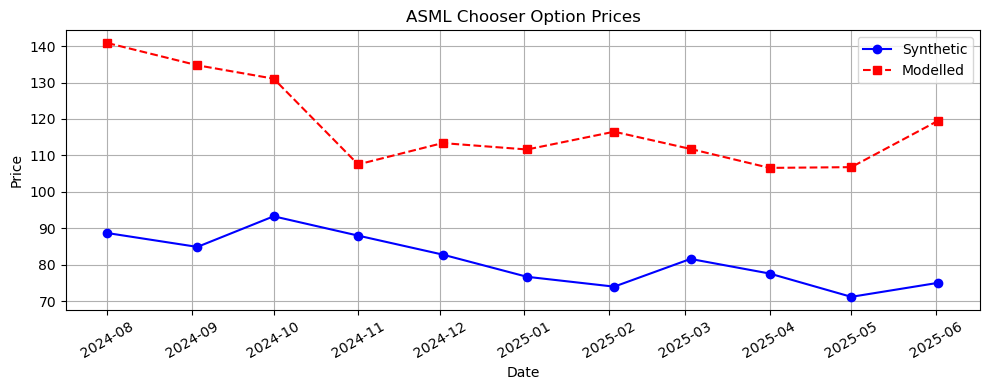

In [155]:
plt.figure(figsize=(10, 4))
plt.plot(comparison_df['Date'], comparison_df['Synthetic_Chooser'], 'b-o', label='Synthetic')
plt.plot(comparison_df['Date'], comparison_df['Modelled_Chooser'], 'r--s', label='Modelled')
plt.title('ASML Chooser Option Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## References

* https://github.com/YanaSSS/model-stock-price-dynamics-usingSDE/blob/master/Modeling%20Stock%20Price%20Dynamics%2C%20using%20Stochastic%20Differential%20Equation.ipynb